# Exploratory Data Analysis

This notebook serves to analyse the data from <i>news_popularity.db</i>, gain insight on the underlying relations between the variables and find out which variables will affect the target value most.

## Section 1: Fetching and Processing of data

### 1.1 Basic analysis

In [1]:
import sqlite3
import pandas as pd
import numpy as np

db = sqlite3.connect("data/news_popularity.db")

arti_df = pd.read_sql_query("SELECT * from articles", db)
desc_df = pd.read_sql_query("SELECT * from description", db)
kw_df = pd.read_sql_query("SELECT * from keywords", db)

Let's first take a look at some basic information we can get from the data provided.

In [2]:
print("Total number of articles provided = %d" % len(arti_df))

Total number of articles provided = 39644


In [3]:
print("Is the url column sorted in an increasing order? %r" % arti_df['url'].is_monotonic)
print("URL of 1st article in the dataset: %s" % arti_df['url'][0])
print("URL of last article in the dataset: %s\n" % arti_df['url'][39643])

arti_df['date_published'] = pd.to_datetime(arti_df['url'].str.slice(start=20,stop=31))
print("Oldest article is published on %s" % arti_df['date_published'].min().date())
print("Newest article is published on %s\n" % arti_df['date_published'].max().date())

print("Oldest article in data is published %d days before dataset acquisition" % arti_df['timedelta'].max())
print("Newest article in data is published %d days before dataset acquisition\n" % arti_df['timedelta'].min())

arti_df['date_acquired'] = arti_df['date_published'] + pd.to_timedelta(arti_df['timedelta'], unit='D')
print("Earliest date for article acquisition = %s" % arti_df['date_acquired'].min().date())
print("Latest date for article acquisition = %s" % arti_df['date_acquired'].max().date())

Is the url column sorted in an increasing order? True
URL of 1st article in the dataset: http://mashable.com/2013/01/07/amazon-instant-video-browser/
URL of last article in the dataset: http://mashable.com/2014/12/27/youtube-channels-2015/

Oldest article is published on 2013-01-07
Newest article is published on 2014-12-27

Oldest article in data is published 731 days before dataset acquisition
Newest article in data is published 8 days before dataset acquisition

Earliest date for article acquisition = 2015-01-03
Latest date for article acquisition = 2015-01-08


Given that the url is sorted in an increasing order, comparing the urls of the first and last article, we can deduce that the articles in the dataset are acquired from <i>mashable.com</i> and is sorted according to year, month and date.

By extracting the date from the url and performing addition of the timedeltas to the dates of each article, we obtain the dates of article acquisiton.

The oldest article acquired in the dataset is dated <b>2013-01-07</b> and the newest <b>2014-12-27</b>.

The oldest article is <b>731 days old</b> upon acquisition and the newest <b>8 days old</b>.

The dataset is acquired over a period of 6 days from <b>2015-01-03</b> to <b>2015-01-08</b>

In [4]:
print("Number of articles published on a Monday = %d" % arti_df.loc[arti_df['weekday'] == 'monday', ['weekday']].count())
print("Number of articles published on a Tuesday = %d" % arti_df.loc[arti_df['weekday'] == 'tuesday', ['weekday']].count())
print("Number of articles published on a Wednesday = %d" % arti_df.loc[arti_df['weekday'] == 'wednesday', ['weekday']].count())
print("Number of articles published on a Thursday = %d" % arti_df.loc[arti_df['weekday'] == 'thursday', ['weekday']].count())
print("Number of articles published on a Friday = %d" % arti_df.loc[arti_df['weekday'] == 'friday', ['weekday']].count())
print("Number of articles published on a Saturday = %d" % arti_df.loc[arti_df['weekday'] == 'saturday', ['weekday']].count())
print("Number of articles published on a Sunday = %d" % arti_df.loc[arti_df['weekday'] == 'sunday', ['weekday']].count())

Number of articles published on a Monday = 6661
Number of articles published on a Tuesday = 7390
Number of articles published on a Wednesday = 7435
Number of articles published on a Thursday = 7267
Number of articles published on a Friday = 5701
Number of articles published on a Saturday = 2453
Number of articles published on a Sunday = 2737


In [5]:
print("Number of articles without proper data channel label = %d" % desc_df['data_channel'].isna().sum())
print(desc_df['data_channel'].value_counts())

Number of articles without proper data channel label = 6134
world            8427
technology       7346
entertainment    7057
business         6258
social_media     2323
lifestyle        2099
Name: data_channel, dtype: int64


In [6]:
print("Maximum number of shares amongst the articles available: %d" % arti_df['shares'].max())
print("Minimum number of shares amongst the articles available: %d" % arti_df['shares'].min())
print("Average number of shares across all articles available: %d" % arti_df['shares'].mean())

Maximum number of shares amongst the articles available: 843300
Minimum number of shares amongst the articles available: 1
Average number of shares across all articles available: 3395


### 1.2 Data processing

#### 1.2.1 Categorical data

In [7]:
arti_df.replace(to_replace='monday', value = '1', inplace=True)
arti_df.replace(to_replace='tuesday', value = '2', inplace=True)
arti_df.replace(to_replace='wednesday', value = '3', inplace=True)
arti_df.replace(to_replace='thursday', value = '4', inplace=True)
arti_df.replace(to_replace='friday', value = '5', inplace=True)
arti_df.replace(to_replace='saturday', value = '6', inplace=True)
arti_df.replace(to_replace='sunday', value = '7', inplace=True)
arti_df = arti_df.astype({'weekday':'int64'})

desc_df.replace(to_replace='entertainment', value='1', inplace=True)
desc_df.replace(to_replace='business', value='2', inplace=True)
desc_df.replace(to_replace='world', value='3', inplace=True)
desc_df.replace(to_replace='technology', value='4', inplace=True)
desc_df.replace(to_replace='lifestyle', value='5', inplace=True)
desc_df.replace(to_replace='social_media', value='6', inplace=True)
desc_df['data_channel'] = desc_df['data_channel'].fillna('7')
desc_df = desc_df.astype({'data_channel':'int64'})

Given that we have categorical data in the dataset, specifically the <i>data_channel</i> column in the <i>descriptions</i> table and the <i>weekday</i> column in the <i>articles</i> table, it is appropriate to convert them to numerical values for visualisations and training data. 

Articles with NaN values under the <i>data_channel</i> column is not classified under any categories on the mashable website, possibly because they do not fit under the available categories, and is categorised under the 'others' category. Hence, such articles will be labelled appropriately to reflect the difference in categories.

The url column will be dropped as each url is unique, similar to the ID of each article and serves no purpose other than to direct the users to the appropriate article. The number of shares will not be affected by the url.

##### 1.2.2 Pairwise correlation between variables

Let's look at the correlation between the variables to better determine the impact of each variable on the target <i>shares</i>

All correlation coefficient calculations are done excluding the NaN values

###### 1.2.2.1 Pearson correlation coefficient

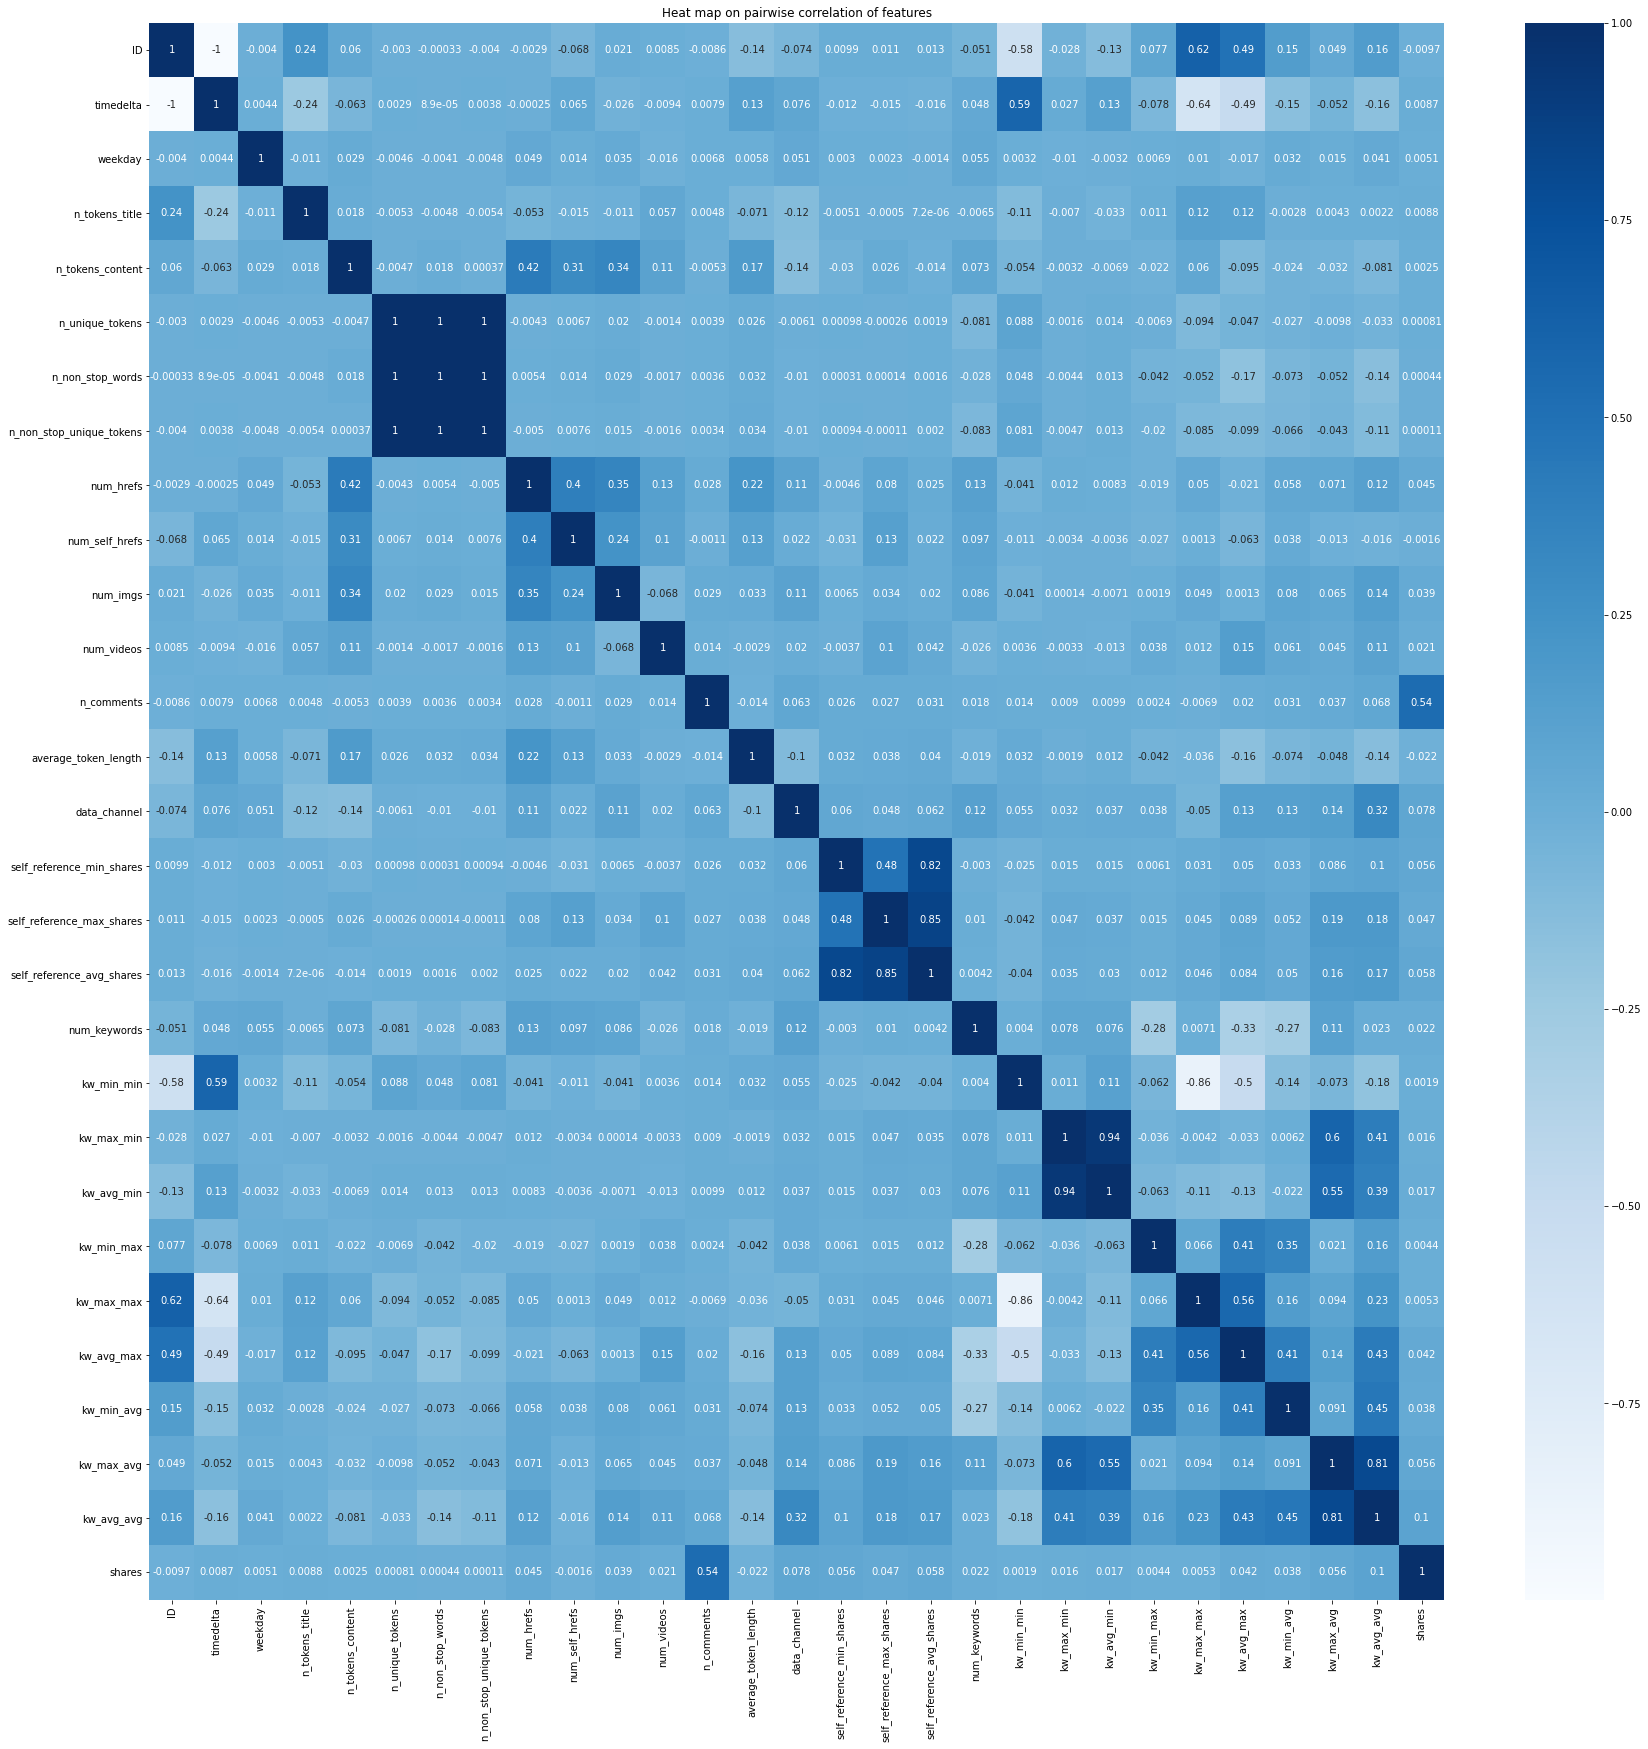

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

temp_df = pd.merge(arti_df, desc_df, on='ID', how='outer')
full_df = pd.merge(temp_df, kw_df, on='ID', how='outer')

cols = list(full_df.columns.values)
cols.remove('shares')
cols.append('shares')
full_df = full_df[cols]

#Using Pearson Correlation
plt.figure(figsize=(29,29))
cor = full_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.title("Heat map on pairwise correlation of features")
plt.show()

Looking at the heatmap for Pearson correlation coefficient, a measure of the linear relationship between 2 variables, defined as the covariance of the variables divided by the product of their standard deviations, it can be seen that there are quite a number of variables that are strongly correlated to each other(having a correlation coefficient(CC) magnitude of 0.9 or more).

<i>n_unique_tokens</i>, <i>n_non_stop_words</i> and <i>n_non_stop_unique_tokens</i> all have a CC of +1 with each other.
This is because unique words is the count of how many different words there are in the article and non-stop words, though possibly having a greater count, is a subset of unique words, thereby explaining the strongest positive correlation between the three variables.

<i>kw_max_min</i> has a CC of +0.94 with <i>kw_avg_min</i> because as the maximum shares increases, the average shares increases as a result.

<i>n_token_title</i> has a CC of +0.0000072, closest to 0 on the CC heatmap, with <i>self_reference_avg_shares</i> indicating that there are no linear correlation between these two variables.

Out of all the variables, <i>num_comments</i> has the highest CC of +0.54 with the target <i>shares</i>. This is possibly because the article with more shares may have more points for discussion and generally results in more comments from people.

Theoretically speaking, the longer the article has been published, the longer time it has to garner shares and is likely to have more shares as compared to the articles that have been published, <i>timedelta</i> has a CC of +0.0087 with the target <i>shares</i>, indicating that the number of shares of an article is not linearly related to how long it has been published.

#### 1.2.3 Invalid / NaN values

Invalid/NaN values

In [9]:
print("Difference in number of rows between articles table and keywords table = %d\n" % (len(arti_df) - len(kw_df)))

full_df.isna().sum()

Difference in number of rows between articles table and keywords table = 3964



ID                               0
url                              0
timedelta                        0
weekday                          0
date_published                   0
date_acquired                    0
n_tokens_title                   0
n_tokens_content                 0
n_unique_tokens                  0
n_non_stop_words                 0
n_non_stop_unique_tokens         0
num_hrefs                      793
num_self_hrefs                 793
num_imgs                      1586
num_videos                   18633
n_comments                       0
average_token_length             0
data_channel                     0
self_reference_min_shares      793
self_reference_max_shares      793
self_reference_avg_shares      793
num_keywords                  3964
kw_min_min                    3964
kw_max_min                    3964
kw_avg_min                    3964
kw_min_max                    3964
kw_max_max                    3964
kw_avg_max                    3964
kw_min_avg          

The columns with the most NaN values is the <i>num_videos</i> column at 18633.

Following the merging of the tables, NaN values have been introduced to 3964 rows under the 10 columns belonging to the <i>keywords</i> table, which matches the difference in rows between the articles table and the keywords table.

The <i>num_imgs</i> column has 1586 NaN values.

The descriptions table has 793 NaN values across the <i>num_hrefs</i>, <i>num_self_hrefs</i>, <i>self_reference_min_shares</i>, <i>self_reference_max_shares</i>, <i>self_reference_avg_shares</i> columns each, which arouses suspicions as to if these rows may have NaN values across the aforementioned columns.

In [10]:
hrefs_index = desc_df['num_hrefs'].index[desc_df['num_hrefs'].apply(np.isnan)]
self_hrefs_index = desc_df['num_self_hrefs'].index[desc_df['num_self_hrefs'].apply(np.isnan)]
sr_min_index = desc_df['self_reference_min_shares'].index[desc_df['self_reference_min_shares'].apply(np.isnan)]
sr_max_index = desc_df['self_reference_max_shares'].index[desc_df['self_reference_max_shares'].apply(np.isnan)]
sr_avg_index = desc_df['self_reference_avg_shares'].index[desc_df['self_reference_avg_shares'].apply(np.isnan)]


print("Does the indices of the rows with NaN values in the num_hrefs columns match that of num_self_hrefs column?")
print(hrefs_index.to_list() == self_hrefs_index.to_list())
print("Does the indices of the rows with NaN values in the self_reference_min_shares columns match that of self_reference_max_shares column?")
print(sr_min_index.to_list() == sr_max_index.to_list())
print("Does the indices of the rows with NaN values in the self_reference_max_shares columns match that of self_reference_avg_shares column?")
print(sr_min_index.to_list() == sr_avg_index.to_list())
print("Does the indices of the rows with NaN values in the self_reference_min_shares columns match that of num_hrefs column?")
print(sr_min_index.to_list() == hrefs_index.to_list())

Does the indices of the rows with NaN values in the num_hrefs columns match that of num_self_hrefs column?
True
Does the indices of the rows with NaN values in the self_reference_min_shares columns match that of self_reference_max_shares column?
True
Does the indices of the rows with NaN values in the self_reference_max_shares columns match that of self_reference_avg_shares column?
True
Does the indices of the rows with NaN values in the self_reference_min_shares columns match that of num_hrefs column?
True


Upon compiling the indices of the rows with NaN values under each of the aforementioned columns, and comparing the list of indices, the indices turned out to be the same across the 5 columns, which means the 793 articles does not have data under <i>num_hrefs</i>, <i>num_self_hrefs</i>, <i>self_reference_min_shares</i>, <i>self_reference_max_shares</i> and <i>self_reference_avg_shares</i> columns

In [11]:
valid_df = full_df.dropna()
num_rows_lost = len(full_df) - len(valid_df)
percentage_loss = (num_rows_lost / len(full_df)) * 100
print("Total number of rows before removing missing values = {}".format(len(full_df)))
print("Total number of rows after removing missing values = {}".format(len(valid_df)))
print("Number of rows removed = {}".format(num_rows_lost))
print("Percentage of rows lost = {:4.2f}%".format(percentage_loss))

Total number of rows before removing missing values = 39644
Total number of rows after removing missing values = 17831
Number of rows removed = 21813
Percentage of rows lost = 55.02%


The number of rows with NaN values is 21813, which is 55.02% of the entire dataset. Blindly removing those rows could possibly lead to severe accuracy loss.

The 793 rows that has NaN values in the <i>num_hrefs</i>, <i>num_self_hrefs</i>, <i>self_reference_min_shares</i>, <i>self_reference_max_shares</i>, <i>self_reference_avg_shares</i> columns as well as the 3964 rows that has NaN values under the columns for the kw_table is lacking data in 17 of the 29 columns in dataset. Imputing values across more than half the columns available will lead to inaccurate results. Assuming the NaN values are all in different rows, removing those rows will lead to at most 12% loss in data, leaving a relatively large dataset of 34887 rows of data.

In [12]:
desc_df.drop(hrefs_index,inplace=True)
temp_df = pd.merge(arti_df, desc_df, on='ID', how='inner')
valid_df = pd.merge(temp_df,  kw_df, on='ID', how='inner')

num_rows_lost = len(full_df) - len(valid_df)
percentage_loss = (num_rows_lost / len(full_df)) * 100
print("Total number of rows before = {}".format(len(full_df)))
print("Total number of rows after = {}".format(len(valid_df)))
print("Number of rows removed = {}".format(num_rows_lost))
print("Percentage of rows lost = {:4.2f}%".format(percentage_loss))

Total number of rows before = 39644
Total number of rows after = 34959
Number of rows removed = 4685
Percentage of rows lost = 11.82%


With the removal of the 793 rows that has NaN values in the <i>num_hrefs</i>, <i>num_self_hrefs</i>, <i>self_reference_min_shares</i>, <i>self_reference_max_shares</i>, <i>self_reference_avg_shares</i> columns as well as the 3964 rows that has NaN values under the columns for the kw_table, we now have 34959 rows of data mostly filled, with the exception of that of the <i>num_images</i> and <i>num_videos</i> columns.

The loss of data is approximately 11.82%.

#### 1.2.3 Imputing values

The NaN values under the <i>num_imgs</i> and <i>num_videos</i> columns will be imputed using the KNN imputer as the articles of similar content and statistics is more likely to have a similar number of images and videos.

In [13]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=20, weights='distance')
x = valid_df.drop(columns=['shares', 'url', 'date_published','date_acquired', 'ID'])
y = valid_df['shares']
imputer.fit(x, y)
x_trans = imputer.transform(x)
column_names = ['timedelta','weekday','n_tokens_title','n_tokens_content','n_unique_tokens',
                'n_non_stop_words','n_non_stop_unique_tokens','num_hrefs','num_self_hrefs','num_imgs',
                'num_videos','n_comments','average_token_length','data_channel','self_reference_min_shares',
                'self_reference_max_shares','self_reference_avg_shares','num_keywords','kw_min_min','kw_max_min',
                'kw_avg_min','kw_min_max','kw_max_max','kw_avg_max','kw_min_avg','kw_max_avg','kw_avg_avg']
imp_df = pd.DataFrame.from_records(x_trans, columns=column_names)

Various columns will be dropped due to various reasons.

<i>ID</i> and <i>url</i> are dropped because they are similar to the index, unique to each article and assigned upon publication of the article and is not data generated after the article is published.

<i>date_acquired</i> and <i>date_published</i> are dropped because <i>timedelta</i> is better than these 2 columns at providing data on how long the article had been published.

<i>self_reference_min_shares</i>, <i>self_reference_max_shares</i> and <i>self_reference_avg_shares</i> are dropped because they are detailed statistics on the target <i>shares</i>.

<i>kw_min_min</i>, <i>kw_max_min</i>, <i>kw_avg_min</i>, <i>kw_min_max</i>, <i>kw_max_max</i>, <i>kw_avg_max</i>, <i>kw_min_avg</i>, <i>kw_max_avg</i> and <i>kw_avg_avg</i> are dropped because they are detailed statistics on the target <i>shares</i> based on the keywords.

In [14]:
imp_df.drop(columns=['self_reference_min_shares','self_reference_max_shares',
                      'self_reference_avg_shares'],inplace=True)
imp_df.drop(columns=['kw_min_min','kw_max_min','kw_avg_min',
                    'kw_min_max','kw_max_max','kw_avg_max',
                    'kw_min_avg','kw_max_avg','kw_avg_avg'], inplace=True)

## Section 2: Feature Selection Using <i>scikit-learn</i>

With a total of 15 features left, we can make use of the scikit-learn library to assist us in identifying the feature that affects the target the most. There are 2 methods, Recursive Feature Elimination(RFE) and by making use of the models. For both methods, a linear model and an ensemble model has been used.

### 2.1 Recursive Feature Elimination(RFE)

In [15]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

model_LR = LinearRegression()
lr_rfe = RFECV(model_LR)
lr_rfe.fit(imp_df,y)
temp = pd.Series(lr_rfe.support_,index = imp_df.columns)
selected_features_rfe = temp[temp==True].index
print("Features selected through RFECV using LinearRegression: ")
print(selected_features_rfe)
       
model_DTR = DecisionTreeRegressor()
dtr_rfe = RFECV(model_DTR)
dtr_rfe.fit(imp_df,y)
temp = pd.Series(dtr_rfe.support_,index = imp_df.columns)
selected_features_rfe = temp[temp==True].index
print("Features selected through RFECV using DecisionTreeRegressor, sorted by rank: ")
print(selected_features_rfe)

Features selected through RFECV using LinearRegression: 
Index(['weekday', 'n_tokens_title', 'n_unique_tokens', 'n_non_stop_words',
       'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs',
       'num_videos', 'n_comments', 'average_token_length', 'data_channel',
       'num_keywords'],
      dtype='object')
Features selected through RFECV using DecisionTreeRegressor, sorted by rank: 
Index(['n_comments'], dtype='object')


The features selected through RFECV using LinearRegression are <i>weekday</i>, <i>n_tokens_title</i>, <i>n_unique_tokens</i>, <i>n_non_stop_words</i>, <i>n_non_stop_unique_tokens</i>, <i>num_hrefs</i>, <i>num_self_hrefs</i>, <i>num_imgs</i>, <i>num_videos</i>, <i>n_comments</i>, <i>average_token_length</i>, <i>data_channel</i>, <i>num_keywords</i>. a total of 13 features.

The only feature selected through RFECV using DecisionTreeRegressor is <i>n_comments</i>.

### 2.2 Making use of the models

#### 2.2.1 L1-based feature selection using LassoCV

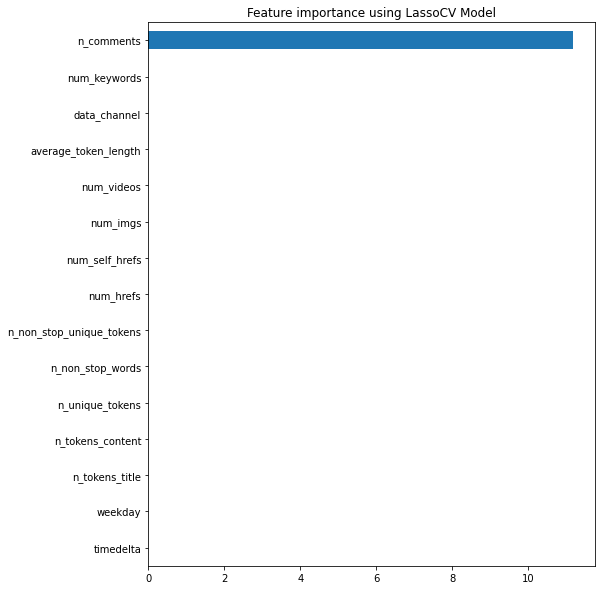

Best alpha using built-in LassoCV: 451351.524043


In [16]:
from sklearn.linear_model import LassoCV
import matplotlib
import matplotlib.pyplot as plt

reg = LassoCV()
reg.fit(imp_df, y)
coef = pd.Series(reg.coef_, index = imp_df.columns)
imp_coef = coef.sort_values()

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using LassoCV Model")
plt.show()

print("Best alpha using built-in LassoCV: %f" % reg.alpha_)

As seen from the horizontal bar graph, <i>n_comments</i> is the only variable that is important. Being a linear model, the result obtained coincides with the observation that there is a positive correlation between <i>n_comments</i> and the target <i>shares</i> previously mentioned in <b>Section 1.2.2.1 Pearson Correlation Coefficient</b>.

#### 2.2.2 Tree-based feature selection using RandomForestRegressor

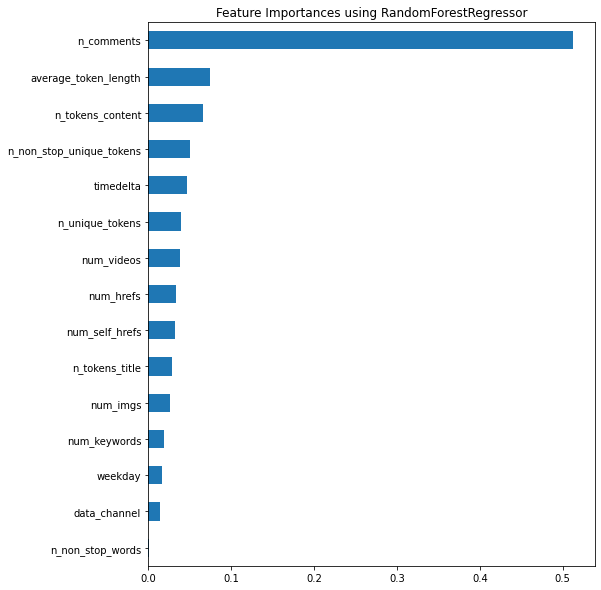

In [17]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
rfr.fit(imp_df, y)
feat_importances = pd.Series(rfr.feature_importances_, index = imp_df.columns)
sorted_imp = feat_importances.sort_values()
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
sorted_imp.plot(kind='barh')
plt.title("Feature Importances using RandomForestRegressor")
plt.show()

Looking at the results of the feature importance, it can be seen that <i>n_comments</i> is overwhelmingly important feature, leading the other variables by a large margin, hitting a value of over 0.5. <i>average_token_length</i>, the second ranked variable barely hit the value of 0.1. The rest of the variables all have values between 0 and 0.1, with the exception of <i>n_non_stop_words</i> having a value of 0, being regarded as a variable of no importance.

### 2.4 Analysis on the results of the 3 methods

One thing all the methods can agree on, is that the <i>n_comments</i> is the most important feature, with RFE through DecisionTreeRegressor and L1-based feature selection using LassoCV selecting it as the only important feature.

The linear models used, LinearRegression and LassoCV did not agree on the number of features. The LinearRegression model did reduce the number of features from 15 to 13, removing <i>timedelta</i> and <i>n_tokens_content</i>

Making use of the RandomForestRegressor, the only feature eliminated is <i>n_non_stop_words</i>, with most features scoring less than 0.1.

## Section 3: Summary

In conclusion, through basic data analysis, it was discovered that the dataset was acquired from the <i>mashable.com</i> website over a period of 5 days from 2015-01-03 to 2015-01-08, consisting of 39644 articles in total, with the oldest article being 731 days old and newest article 8 days old upon acquisition of dataset.

The highest number of shares of an article in the dataset is 843300 and the least number of shares is 1.

Out of the 39644 articles, 793 articles under the description table has missing data on links/hrefs and resultant databased on links/hrefs under the description table. 3964 of the articles did not have data on the keywords and its relation between keywords and the shares under the keywords table.

Looking at the Pearson correlation coefficient, the <i>n_unique_tokens</i>, <i>n_non_stop_words</i> and <i>n_non_stop_unique_tokens</i> variables are the most correlated variables with a correlation coefficient of +1. The <i>n_token_title</i> and <i>self_reference_avg_shares</i> variables are the least correlated with a correlation coefficient of 0.0000072.

The only variable that is moderately correlated with with the target <i>shares</i> is <i>n_comments</i> with a correlation coefficient of +0.54.

The rows with missing values under the description table and the keywords table has been removed as the lack of data across multiple variables can lead to less accurate results through the imputation with a K-nearest neighbours imputer, because there are lesser data points for reference to work with, leaving the resulting dataset with 34959 rows.

Through the feature selection using the <i>scikit-learn</i> library, 2 methods, each using a linear and an ensemble model, were implemented to determine the features that affects the target value the most and after the 4 runs, the feature that is most important is <i>n_comments</i>, with varying opinions on the rest of the features.